set paths to locations that will need to be referenced

In [1]:
ROOT = '/Users/garrettmccue/projects/cnn-alzheimers'
data = f'{ROOT}/data'

In [2]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.segmentation import watershed as skwater

%matplotlib inline

os.chdir(ROOT)
os.getcwd()


'/Users/garrettmccue/projects/cnn-alzheimers'

In [3]:
def ShowImage(title,img):
  plt.figure(figsize=(10, 10))
  plt.imshow(img,cmap='gray')
  plt.axis('off')
  plt.title(title)
  plt.show()

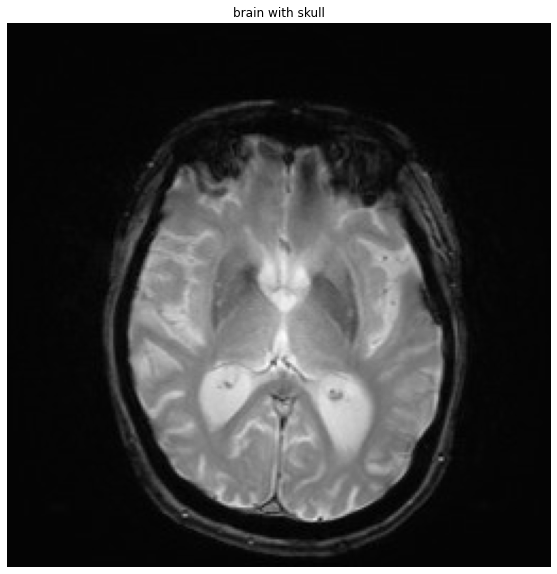

In [4]:
# set the dir to the ADNI AD training dir
folder_dir = f'{data}/ADNI/train/AD'
img = cv2.imread(os.path.join(folder_dir, os.listdir(folder_dir)[0]))
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ShowImage(title='brain with skull', img=img)

In this image we can see the brain as well as the skull. The goal skull stripping is to create a mask to extract only the brain and removing the skull.

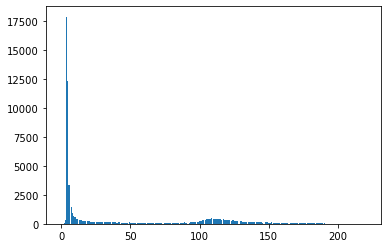

In [5]:
    #Make a histogram of the intensities in the grayscale image
plt.hist(img.ravel(), 256)
plt.show()

we see that the pixel intensities are bimodal, which we can leverage to create a threshold using [Otsu's Binarization](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)

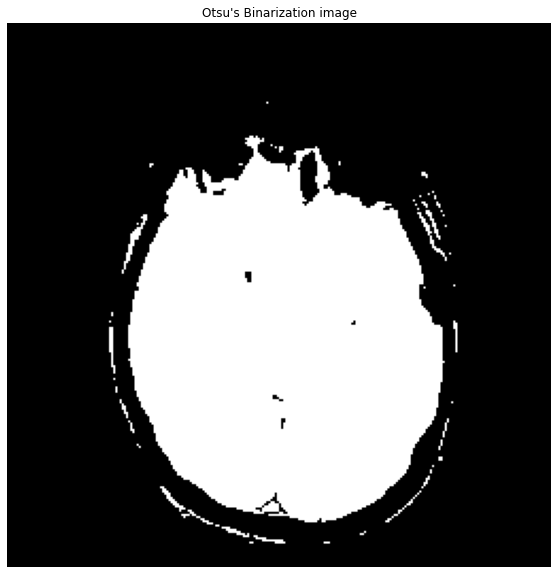

In [6]:
#Threshold the image to binary using Otsu's method
ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
ShowImage('Otsu\'s Binarization image',thresh)

After Otsu's binarization we can see the brain and a white border around the brain, which is the skull. now we can create a mask based on the pixel colors. This can be done by extracting the connected components and finding the largest one, which will represent the brain. 

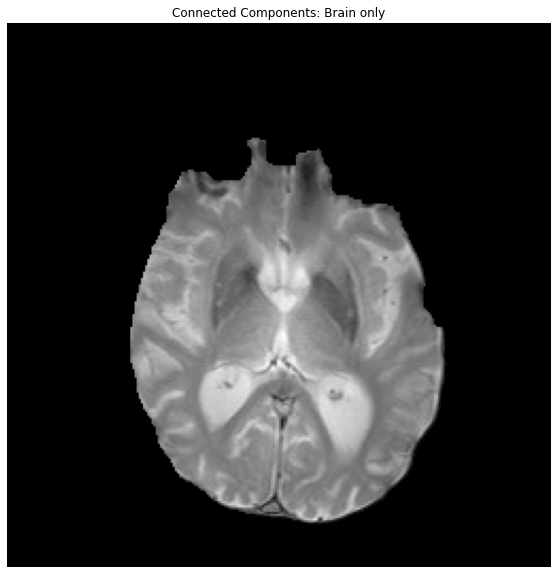

In [11]:
#Threshold the image to binary using Otsu's method
ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
ret, markers = cv2.connectedComponents(thresh)

#Get the area taken by each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
#Get label of largest component by area
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
#Get pixels which correspond to the brain
brain_mask = markers==largest_component

# close the holes in the mask to retain the full brain image using a closing transformation
brain_mask = np.uint8(brain_mask)
kernel = np.ones((8,8),np.uint8)
closing = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)

brain_out = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
# pixels that arent apart of the brain are set to 0 so they become black.
brain_out[closing==False] = 0
ShowImage('Connected Components: Brain only', brain_out)

We can now compile all of the steps into a function in order to process all images.

In [12]:

def strip_skull(img):
    
    # ensure the image is in grayscale
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #Threshold the image to binary using Otsu's method
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    ret, markers = cv2.connectedComponents(thresh)

    #Get the area taken by each component. Ignore label 0 since this is the background.
    marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
    #Get label of largest component by area
    largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
    #Get pixels which correspond to the brain
    brain_mask = markers==largest_component

    # close the holes in the mask to retain the full brain image using a closing transformation
    brain_mask = np.uint8(brain_mask)
    kernel = np.ones((8,8),np.uint8)
    closing = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)

    brain_out = img.copy()
    #In a copy of the original image, clear those pixels that don't correspond to the brain
    # pixels that arent apart of the brain are set to 0 so they become black.
    brain_out[closing==False] = 0
    
    return brain_out

we can test this function to make sure it works as expected with another image.

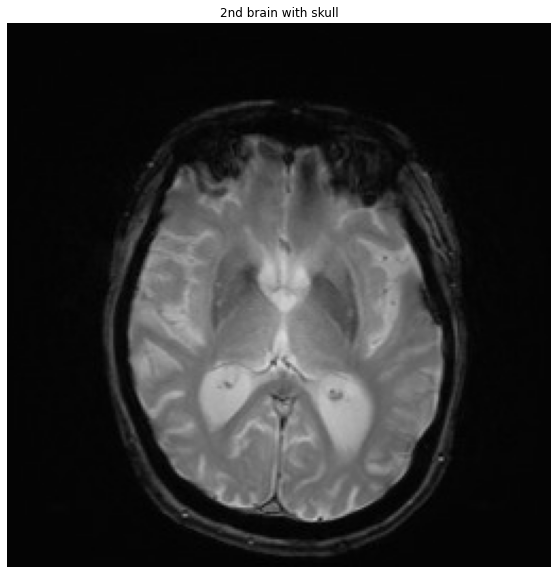

In [13]:
img2 = cv2.imread(os.path.join(folder_dir, os.listdir(folder_dir)[0]))
ShowImage(title='2nd brain with skull', img=img2)


apply the skull_strip() func to the image

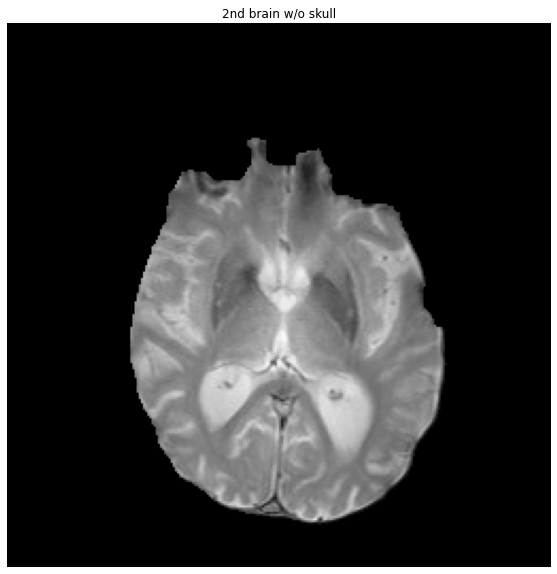

In [14]:
img2 = strip_skull(img2)
ShowImage(title='2nd brain w/o skull', img=img2)

the function worked as expected and can be applied to all images. This will be done on the fly when loading images from directory using tensorflows ImageDataGen's `preprocessing_function` which allows for a custom function to be used.